# Text Clustering with K-Means
In the present notebook we will use the [k-means algorithm](https://www.datascience.com/blog/k-means-clustering), a simple and popular __*unsupervised clustering*__ algorithm, to cluster the national anthems of the world into different groups.

The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed defined number (k) of centroids in a dataset. A centroid refers to a cluster, which is a collection of data points aggregated together because of certain similarities with each other. The ‘means’ in the K-means refers to the averaging of the data; that is, finding the centroid. And the algorithm is said to be unsupervised because we have no prior knowledge with regards to the groups or classes of our dataset, that is, we will find the underlying groups in our dataset!

Below we can visualize the algorithm. The green centroids matches the closest datapoints to each one and form clusters, then each centroid moves to the center of each respective group and matches again the closest datapoint to each other.

![alt text](Images/kmeans.gif "Title")

**Steps:**

__1.__ Explore our collection of national anthems (corpus) <br>
__2.__ Data Engineer the dataset to get the best perfomance from the K-means algorithm <br>
__3.__ Run the algorithm many times, each time testing with a different number of clusters <br>
__4.__ Use different metrics to visualize our results and find the best number of clusters (*ie. Why are a total of X clusters better than a total of Y clusters*) <br>
__5.__ Cluster Analysis

**Metrics Utilized for Determining the Best Number of K Cluters:**
- [Elbow Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
- [Silhouette Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

## Importing Libraries:

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
#import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        
import unidecode
from nltk.tokenize                    
import word_tokenize
from nltk                             
import SnowballStemmer
from sklearn.feature_extraction.text  
import TfidfVectorizer
from sklearn.preprocessing            
import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  
import silhouette_samples, silhouette_score
from wordcloud                        
import WordCloud

import plotly.express as px


## Corpus Loading:

We'll use pandas to read the csv file contaning the national anthem for each country and it's corresponding country code. The anthems were extracted from wikipedia and many of them contain words that use non UTF-8 characters (generaly names of places and such), so we'll read the file with the _latin1_ encoding.

Then we'll extract the __Anthem__ column into a list of texts for our corpus.

In [2]:
data = pd.read_csv('anthems.csv', encoding='utf-8')
data.columns = map(str.lower, data.columns)

#continents = ['Europe', 'South_America', 'North_America']
#data = data.loc[data['continent'].isin(continents)]
data

country alpha-2 alpha-3 continent  \
0           Albania      AL     ALB    Europe   
1           Armenia      AM     ARM    Europe   
2           Austria      AT     AUT    Europe   
3        Azerbaijan      AZ     AZE    Europe   
4           Belarus      BY     BLR    Europe   
..              ...     ...     ...       ...   
185         Tunisia      TN     TUN    Africa   
186          Uganda      UG     UGA    Africa   
187  Western Sahara      EH     ESH    Africa   
188          Zambia      ZM     ZMB    Africa   
189        Zimbabwe      ZW     ZWE    Africa   

                                                anthem  
0    Around our flag we stand united, With one wish...  
1    Our Fatherland, free, independent, That has fo...  
2    Land of mountains, land by the river, Land of ...  
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...  
4    We, Belarusians, are peaceful people, Wholehea...  
..                                                 ...  
185  O defenders of the Homeland! Rally around to t...  
186  Oh Uganda! May God uphold Thee, We lay our fut...  
187  O sons of the Sahara! In the battlefield, you ...  
188  Stand and sing of Zambia, proud and free, Land...  
189  Oh lift high the banner, the flag of Zimbabwe ...  

[190 rows x 5 columns]

In [3]:
corpus = data['anthem'].tolist()
corpus[18][0:447]

"O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂ\x81rpÃƒÂ¡d our hero's "

## Corpus Processing

### 1. Stop Words and Stemming
We will do a data engineering routine with our anthems dataset so later we can make a good statistical model. In order to do so, we'll remove all words that don't contribute to the semantic meaning of the text (words that are not within the english alphabet) and keep all of the remaining words in the simplest format possible, so we can apply a function that gives weights to each word without generating any bias or outliers. To do that there are many techniques to clean up our corpus, among them we will remove the most common words ([stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)) and apply [stemming](https://www.researchgate.net/figure/Stemming-process-Algorithms-of-stemming-methods-are-divided-into-three-parts-mixed_fig2_324685008), a technique that reduces a word to it's root.

The methods that apply stemming and stop words removal are listed bellow. We will also define a method that removes any words with less than 2 letters or more than 21 letters to clean our corpus even more.

In [4]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

### 2. The main corpus processing function.

A section back, at the exploration of our dataset, we noticed some words containg weird characters that should be removed. By using RegEx our main processing function will remove unknown ASCII symbols, especial chars, numbers, e-mails, URLs, etc (It's a bit of a overkill, I know). It also uses the auxiliary funcitions defined above.

In [5]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [6]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

'lord bless nation grace bounti extend guard arm strife enemi long torn ill fate bring time relief nation suffer sin past futur brought ancestor carpathian holi peak beauti homeland bendeguz son flow river tisza danub afarpafa!d hero descend root bloom plain kun ripen wheat grape field tokaj drip sweet nectar flag plant wild turk earthwork mafa!tyafa! grave armi whimper vienna proud fort sin anger gather bosom struck lightn thunder cloud plunder mongol arro'

### Statistical Weighting of Words

Now we will apply the [TF-IDF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html) function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

190 rows


0         1         2         3         4         5    6    \
sacr        0.314285  0.000000  0.000000  0.000000  0.095563  0.000000  0.0   
fatherland  0.254830  0.130993  0.077471  0.207215  0.000000  0.083289  0.0   
proclaim    0.246156  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
flag        0.220666  0.113431  0.000000  0.059811  0.067097  0.000000  0.0   
earth       0.202957  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

                 7    8    9    ...       180  181  182  183  184      185  \
sacr        0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
fatherland  0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
proclaim    0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
flag        0.000000  0.0  0.0  ...  0.098082  0.0  0.0  0.0  0.0  0.07072   
earth       0.218313  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   

            186  187       188       189  
sacr        0.0  0.0  0.000000  0.000000  
fatherland  0.0  0.0  0.000000  0.000000  
proclaim    0.0  0.0  0.000000  0.117607  
flag        0.0  0.0  0.067148  0.070286  
earth       0.0  0.0  0.000000  0.000000  

[5 rows x 190 columns]

In [8]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

0         1         2         3         4         5    6    \
sacr        0.314285  0.000000  0.000000  0.000000  0.095563  0.000000  0.0   
fatherland  0.254830  0.130993  0.077471  0.207215  0.000000  0.083289  0.0   
proclaim    0.246156  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
flag        0.220666  0.113431  0.000000  0.059811  0.067097  0.000000  0.0   
earth       0.202957  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

                 7    8    9    ...       180  181  182  183  184      185  \
sacr        0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
fatherland  0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
proclaim    0.000000  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   
flag        0.000000  0.0  0.0  ...  0.098082  0.0  0.0  0.0  0.0  0.07072   
earth       0.218313  0.0  0.0  ...  0.000000  0.0  0.0  0.0  0.0  0.00000   

            186  187       188       189  
sacr        0.0  0.0  0.000000  0.000000  
fatherland  0.0  0.0  0.000000  0.000000  
proclaim    0.0  0.0  0.000000  0.117607  
flag        0.0  0.0  0.067148  0.070286  
earth       0.0  0.0  0.000000  0.000000  

[5 rows x 190 columns]

## K-Means

##### Function that runs the K-Means algorithm *max_k* times and returns a dictionary of each k result

In [9]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'lloyd')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

#### Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [11]:
# Running Kmeans
k = 5
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

In [12]:
kmeans_results.get(4)

KMeans(n_clusters=4, random_state=1)

## Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [13]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

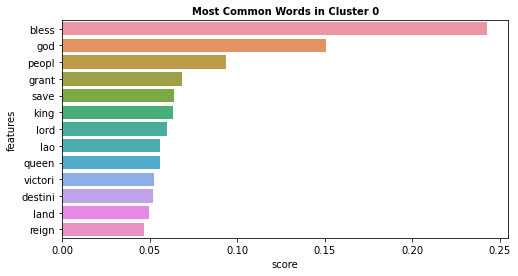

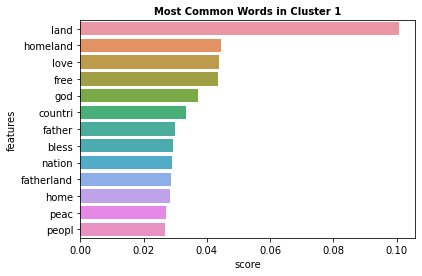

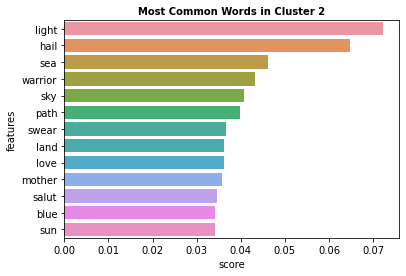

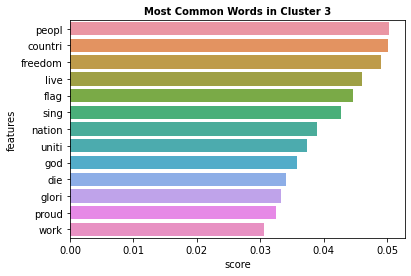

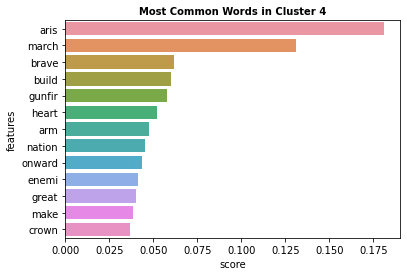

In [14]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#### Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster!

In [15]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(11,7))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

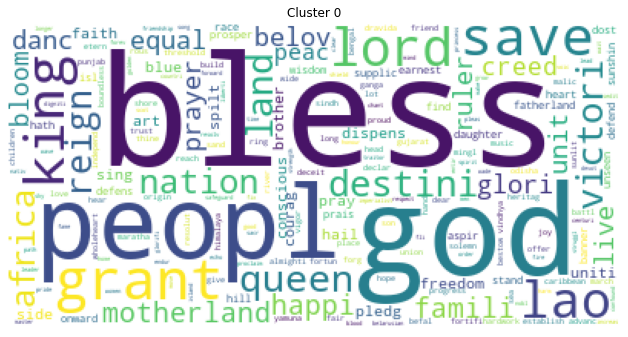

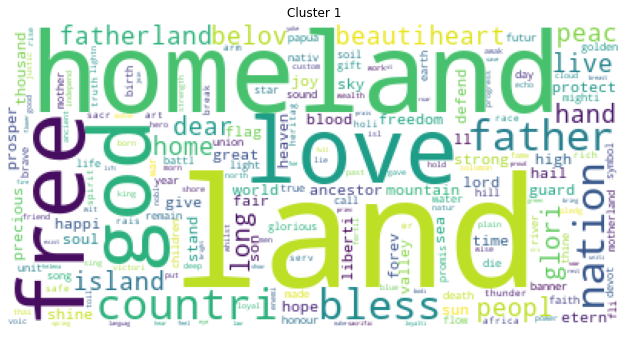

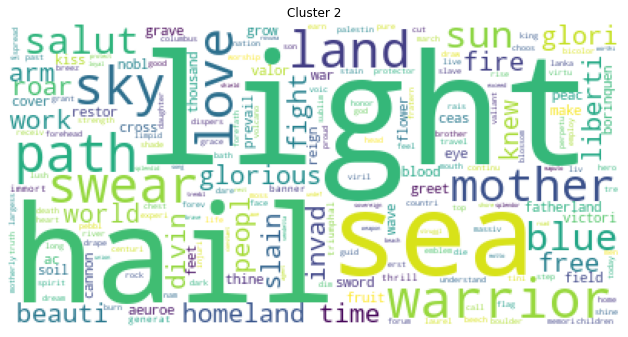

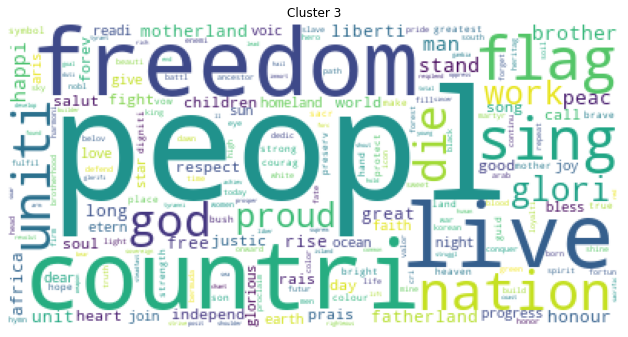

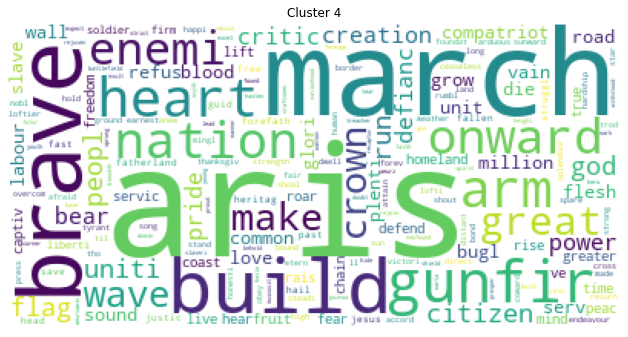

In [16]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

### Preparing our final groups for visualization

Now that we're satisfied with our clustering we should assign which country belongs to which group.

In [17]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

country alpha-2 alpha-3 continent  \
0     Albania      AL     ALB    Europe   
1     Armenia      AM     ARM    Europe   
2     Austria      AT     AUT    Europe   
3  Azerbaijan      AZ     AZE    Europe   
4     Belarus      BY     BLR    Europe   

                                              anthem  label  
0  Around our flag we stand united, With one wish...      3  
1  Our Fatherland, free, independent, That has fo...      3  
2  Land of mountains, land by the river, Land of ...      1  
3  Azerbaijan, Azerbaijan! The glorious Fatherlan...      3  
4  We, Belarusians, are peaceful people, Wholehea...      0

In [18]:
tp0 = data[data['label'] == 'type-3']

In [19]:
tp0[['country','anthem','label',]][50:] 


Empty DataFrame
Columns: [country, anthem, label]
Index: []

In [20]:
tp0

Empty DataFrame
Columns: [country, alpha-2, alpha-3, continent, anthem, label]
Index: []

In [21]:
tp0['label'].value_counts()

Series([], Name: label, dtype: int64)

In [22]:
data

country alpha-2 alpha-3 continent  \
0           Albania      AL     ALB    Europe   
1           Armenia      AM     ARM    Europe   
2           Austria      AT     AUT    Europe   
3        Azerbaijan      AZ     AZE    Europe   
4           Belarus      BY     BLR    Europe   
..              ...     ...     ...       ...   
185         Tunisia      TN     TUN    Africa   
186          Uganda      UG     UGA    Africa   
187  Western Sahara      EH     ESH    Africa   
188          Zambia      ZM     ZMB    Africa   
189        Zimbabwe      ZW     ZWE    Africa   

                                                anthem  label  
0    Around our flag we stand united, With one wish...      3  
1    Our Fatherland, free, independent, That has fo...      3  
2    Land of mountains, land by the river, Land of ...      1  
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...      3  
4    We, Belarusians, are peaceful people, Wholehea...      0  
..                                                 ...    ...  
185  O defenders of the Homeland! Rally around to t...      1  
186  Oh Uganda! May God uphold Thee, We lay our fut...      1  
187  O sons of the Sahara! In the battlefield, you ...      2  
188  Stand and sing of Zambia, proud and free, Land...      3  
189  Oh lift high the banner, the flag of Zimbabwe ...      1  

[190 rows x 6 columns]

In [23]:
data['label'].value_counts().sort_values()

0    12
4    13
2    23
3    63
1    79
Name: label, dtype: int64

In [31]:
df_graph[df_graph['label'] =='type-2']

country alpha-2 alpha-3      continent  \
9                      Cyprus      CY     CYP         Europe   
11                    Denmark      DK     DNK         Europe   
17                     Greece      GR     GRC         Europe   
24                  Lithuania      LT     LTU         Europe   
26                      Malta      MT     MLT         Europe   
32                   Portugal      PT     PRT         Europe   
35   Russian Federation (the)      RU     RUS         Europe   
47                      Chile      CH     CHL  South_America   
48                   Colombia      CO     COL  South_America   
62         Dominican Republic      DO     DOM  North_America   
63                   Honduras      HN     HND  North_America   
65                  Nicaragua      NI     NIC  North_America   
66                 Costa Rica      CR     CRI  North_America   
67                     Panama      PA     PAN  North_America   
68                Puerto Rico      PR     PRI  North_America   
92                 Bangladesh      BD     BGD           Asia   
102                     Japan      JP     JPN           Asia   
118                 Palestine      PS     PSE           Asia   
120                     Qatar      QA     QAT           Asia   
124                 Sri Lanka      LK     LKA           Asia   
166                   Morocco      MA     MAR         Africa   
167                Mozambique      MZ     MOZ         Africa   
187            Western Sahara      EH     ESH         Africa   

                                                anthem   label  
9    We knew thee of old, O, divinely restored, By ...  type-2  
11   There is a lovely country it stands with broad...  type-2  
17   We knew thee of old, O, divinely restored, By ...  type-2  
24   Lithuania, our dear homeland, Land of worthy h...  type-2  
26   Guard, Lord, forever, as you've done erst and ...  type-2  
32   Heroes of the sea, noble people, Valiant and i...  type-2  
35   Russia Ã¢â‚¬â€œ our holy nation Russia Ã¢â‚¬â€...  type-2  
47   Beloved Homeland, receive the vows That Chile ...  type-2  
48   Oh, unwithering glory! Oh, immortal jubilance!...  type-2  
62   Brave , Let’s raise our song with vivid emotio...  type-2  
63   Your flag, your flag is a piece of sky crossed...  type-2  
65   Hail to thee, Nicaragua! On thy land roars the...  type-2  
66   Noble homeland, your beautiful flag Expresses ...  type-2  
67   At last we reached victory In the joyous field...  type-2  
68   The land of Borinquen where I have been born i...  type-2  
92   My golden Bengal, I love thee. Forever thy ski...  type-2  
102  May your reign Continue for a thousand, eight ...  type-2  
118  Warrior, warrior, warrior, Oh my land, the lan...  type-2  
120  I Swear, I Swear Swearing by the one who raise...  type-2  
124  Thou Mother Lanka, Oh Mother Lanka we salute, ...  type-2  
166  Root of the free, And of the brav Rising place...  type-2  
167  In the memory of Africa and the World Beautifu...  type-2  
187  O sons of the Sahara! In the battlefield, you ...  type-2

In [24]:
df_graph = data
df_graph.loc[df_graph["label"] == 0, "label"] = "type-0"
df_graph.loc[df_graph["label"] == 1, "label"] = "type-1"
df_graph.loc[df_graph["label"] == 2, "label"] = "type-2"
df_graph.loc[df_graph["label"] == 3, "label"] = "type-3"
df_graph.loc[df_graph["label"] == 4, "label"] = "type-4"
df_graph

country alpha-2 alpha-3 continent  \
0           Albania      AL     ALB    Europe   
1           Armenia      AM     ARM    Europe   
2           Austria      AT     AUT    Europe   
3        Azerbaijan      AZ     AZE    Europe   
4           Belarus      BY     BLR    Europe   
..              ...     ...     ...       ...   
185         Tunisia      TN     TUN    Africa   
186          Uganda      UG     UGA    Africa   
187  Western Sahara      EH     ESH    Africa   
188          Zambia      ZM     ZMB    Africa   
189        Zimbabwe      ZW     ZWE    Africa   

                                                anthem   label  
0    Around our flag we stand united, With one wish...  type-3  
1    Our Fatherland, free, independent, That has fo...  type-3  
2    Land of mountains, land by the river, Land of ...  type-1  
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...  type-3  
4    We, Belarusians, are peaceful people, Wholehea...  type-0  
..                                                 ...     ...  
185  O defenders of the Homeland! Rally around to t...  type-1  
186  Oh Uganda! May God uphold Thee, We lay our fut...  type-1  
187  O sons of the Sahara! In the battlefield, you ...  type-2  
188  Stand and sing of Zambia, proud and free, Land...  type-3  
189  Oh lift high the banner, the flag of Zimbabwe ...  type-1  

[190 rows x 6 columns]

In [30]:
df_graph.label.value_counts()

type-1    79
type-3    63
type-2    23
type-4    13
type-0    12
Name: label, dtype: int64

In [26]:
fig = px.choropleth(df_graph, locations="alpha-3",
                    color="label", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information,
                    color_discrete_sequence=["sandybrown", "deepskyblue", "blue", "pink", "red"],
                    )
fig.show()


In [27]:
fig = px.choropleth(df_graph, locations="alpha-3",
                    color="label", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information,
                    color_discrete_sequence=["sandybrown", "deepskyblue", "blue", "pink", "red"],
                    )
fig.show()


# BERT

### !! Warning: Runnign the follwing line will download 500mb of file in your local mahcine. Run with caution.

In [ ]:
## Run with caution
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
def get_sentense_embedding(sentenses):
    preprocessed_text = bert_preprocess(sentenses)
    vector = bert_encoder(preprocessed_text)['pooled_output']
    return vector

get_sentense_embedding([
    "500$ discount",
    'I eat mango, sweet mango'
])
